In [1]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D, Conv2D
import pandas as pd
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.inception_v3 import InceptionV3
import keras.backend as K

Using TensorFlow backend.


In [2]:
df1 = pd.read_csv('./normal_lap/driving_log.csv', header=None)
df2 = pd.read_csv('./backward_lap/driving_log.csv', header=None)
# df3 = pd.read_csv('./recover_from_left/driving_log.csv', header=None)
print(len(df1))
print(len(df2))
df = pd.concat((df1, df2))
# df = df1

4408
4104


In [11]:
center_img_paths = df[0].values.tolist() + df[1].values.tolist() + df[2].values.tolist()
x_train = np.array([mpimg.imread(img_path.strip()) for img_path in center_img_paths])
y_train = np.array( df[3].values.tolist() + (df[3].values + 0.2).tolist() + (df[3].values - 0.2).tolist())

In [4]:
x_train_flip = np.array([np.fliplr(img) for img in x_train])
y_train_flip = -y_train.copy()

x_train = np.concatenate((x_train, x_train_flip))
y_train = np.concatenate((y_train, y_train_flip))

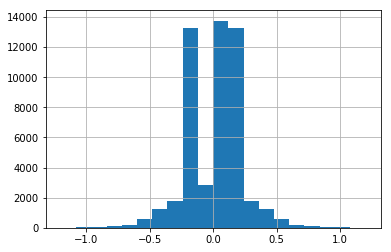

In [5]:
plt.hist(y_train, 20)
plt.grid()
plt.show()

In [6]:
model = Sequential()
# Preprocessing - Crop some top and bottom pixels and normalization.
model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
# NVIDIA's architecture 
model.add(Conv2D(24, (5, 5), strides=(2,2), activation='relu'))
model.add(Conv2D(36, (5, 5), strides=(2,2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2,2), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 33, 64)         36928     
__________

In [8]:
# Imports the Model API
from keras.optimizers import Adam, SGD

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Check the summary of this new model to confirm the architecture
# model.summary()

In [9]:
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, batch_size=32, epochs=3)

Train on 40857 samples, validate on 10215 samples
Epoch 1/3
40857/40857 [==============================] - 444s 11ms/step - loss: 0.0166 - val_loss: 0.0166
Epoch 2/3
40857/40857 [==============================] - 408s 10ms/step - loss: 0.0141 - val_loss: 0.0193
Epoch 3/3
40857/40857 [==============================] - 414s 10ms/step - loss: 0.0135 - val_loss: 0.0140


In [12]:
model.save('model.h5')

dict_keys(['val_loss', 'loss'])


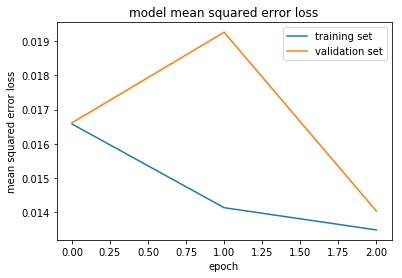

In [13]:
# print the keys contained in the history object
print(hist.history.keys())

# plot the training and validation loss for each epoch
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')